In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install tensorflow=='2.3.0' keras=='2.3.1' numpy=='1.18.5' \
  matplotlib=="3.1.3" cv2=="3.4.2" sklearn=='0.23.1' skimage=="0.15.0"

# <font color=#003091> Clasificación de imágenes con Deep Learning en Keras - ESPECIES DE CORALES </font>

Este notebook introduce los conceptos que se encuentran destrás de una red convolucional y muestra como entrenar una red de clasificación de imágenes con Keras.

In [4]:
import pandas as pd
import numpy as np 
import os
import cv2
import skimage.measure
import matplotlib.pyplot as plt
import random
from random import shuffle
from sklearn.model_selection import train_test_split
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
import matplotlib as mpl
mpl.rc("figure", figsize=(16, 9))

In [5]:
# Método generado para permitir que todas las ejecuciones terminen en una misma ejecución
def do_seeds(sn):
    os.environ['PYTHONHASHSEED']=str(sn)
    np.random.seed(sn)
    tf.random.set_seed(sn)
    random.seed(sn)

do_seeds(0)

## Dataset - Especies de Corales

El objetivo de este dataset es identificar los tipos de corales utilizando una imagen. Por tanto,se trata de un problema real de clasificación.

Este conjunto de datos dispone de 14 clases de corales con un total de 620 imágenes de train y 146 de test.

In [6]:
# Directorios del conjunto de entrenamiento y test
path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/2. CNN/"

train_dir = path+"input/coralspecies/train/"
test_dir = path+"input/coralspecies/Test_Mixed/"
img_rows, img_cols, img_channel = 224, 224, 3

In [7]:
# Obtenemos las clases disponibles (nombres de las carpetas)
clases = os.listdir(train_dir)
clases = [clase for clase in clases if not clase.startswith(".")]
clases_dict = dict(zip(clases, list(range(len(clases)))))
# Se muestran las clases de Corales que se van a predecir
print("Existen un total de {} clases de corales".format(len(clases)))
print("Las clases son: {}".format(clases))

Existen un total de 14 clases de corales
Las clases son: ['DANT', 'MCAV', 'TUNI', 'SPO', 'APAL', 'ACER', 'CNAT', 'MALC', 'MMEA', 'SSID', 'GORG', 'MONT', 'PALY', 'DSTR']


In [8]:
# Se leen las imágenes
#  - Las imágenes están en Carpetas con el nombre de la clase
#  - Para leer las imágenes se utiliza la función "load_img" de Tensorflow y 
#    "img_to_array"
x_dataset = np.array([img_to_array(load_img(os.path.join(train_dir, cl, name),target_size=(img_rows, img_cols))) for cl in clases
           for name in os.listdir(os.path.join(train_dir, cl))])


print(x_dataset.shape)
print('Primera imagen: \n',x_dataset[0,:,:,:])

(620, 224, 224, 3)
Primera imagen: 
 [[[ 10.  14.  13.]
  [ 10.  14.  13.]
  [  9.  13.  12.]
  ...
  [ 27.  32.  12.]
  [ 39.  44.  21.]
  [ 49.  55.  29.]]

 [[ 10.  14.  13.]
  [ 10.  14.  13.]
  [ 10.  14.  13.]
  ...
  [ 14.  18.   4.]
  [ 20.  24.   7.]
  [ 26.  30.  13.]]

 [[ 11.  15.  14.]
  [ 10.  14.  13.]
  [ 10.  14.  13.]
  ...
  [  9.  11.   6.]
  [ 11.  14.   7.]
  [ 14.  17.  10.]]

 ...

 [[109. 178. 147.]
  [ 89. 159. 125.]
  [ 71. 143. 103.]
  ...
  [  6.  12.  12.]
  [  6.  12.  12.]
  [  6.  12.  12.]]

 [[106. 173. 142.]
  [ 95. 165. 129.]
  [ 84. 156. 116.]
  ...
  [  5.  11.  11.]
  [  5.  11.  11.]
  [  5.  11.  11.]]

 [[108. 173. 141.]
  [103. 170. 135.]
  [ 94. 165. 125.]
  ...
  [  5.  11.  11.]
  [  5.  11.  11.]
  [  5.  11.  11.]]]


In [9]:
y_dataset_orig = np.array([[clases_dict[cl]] for cl in clases
           for name in os.listdir(os.path.join(train_dir, cl))])

print('Clases')
print(y_dataset_orig.shape)
print('Primera imagen:',y_dataset_orig[0],"\n")

onehot_encoder = OneHotEncoder(sparse=False)
y_dataset = onehot_encoder.fit_transform(y_dataset_orig)

print('Clases después de aplicar One-Hot encoding:')
print(y_dataset.shape)
print('Primera imagen:',y_dataset[0])

Clases
(620, 1)
Primera imagen: [0] 

Clases después de aplicar One-Hot encoding:
(620, 14)
Primera imagen: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
x_test = np.array([img_to_array(load_img(test_dir+"/"+pos,target_size=(img_rows, img_cols))) for pos in os.listdir(test_dir)])


# Preprocesado de imágenes

Las redes neuronales necesitan que los datos de entrada estén normalizados. Se recomienda que los datos de entrada estén mayormente en el rango de [0,1] o [-1,1].

En este caso, dividimos las imágenes de entrada entre 255
- Nota: Las imágenes RGB (las comunes) contienen [0,255] de Rojo, Verde y Azul. Al dividir entre 255 el rango saliente es de [0,1].

In [11]:
# Almacenar las imágenes en el rango de 0-1
x_dataset = x_dataset/255.
x_test = x_test/255.

In [12]:
x_dataset[0]

array([[[0.03921569, 0.05490196, 0.05098039],
        [0.03921569, 0.05490196, 0.05098039],
        [0.03529412, 0.05098039, 0.04705882],
        ...,
        [0.10588235, 0.1254902 , 0.04705882],
        [0.15294118, 0.17254902, 0.08235294],
        [0.19215687, 0.21568628, 0.11372549]],

       [[0.03921569, 0.05490196, 0.05098039],
        [0.03921569, 0.05490196, 0.05098039],
        [0.03921569, 0.05490196, 0.05098039],
        ...,
        [0.05490196, 0.07058824, 0.01568628],
        [0.07843138, 0.09411765, 0.02745098],
        [0.10196079, 0.11764706, 0.05098039]],

       [[0.04313726, 0.05882353, 0.05490196],
        [0.03921569, 0.05490196, 0.05098039],
        [0.03921569, 0.05490196, 0.05098039],
        ...,
        [0.03529412, 0.04313726, 0.02352941],
        [0.04313726, 0.05490196, 0.02745098],
        [0.05490196, 0.06666667, 0.03921569]],

       ...,

       [[0.42745098, 0.69803923, 0.5764706 ],
        [0.34901962, 0.62352943, 0.49019608],
        [0.2784314 , 0

In [13]:
# Dividir el conjunto de datos en train/validación
seed = 125
x_train, x_val, y_train, y_val = train_test_split(x_dataset, y_dataset, test_size=0.33, random_state=seed)

# Visualización de imágenes

Vamos ahora a ver como se ven las imágenes que tenemos que clasificar. Para estar tarea de visualizar imágenes, vamos a utilizar la función imshow()

In [14]:
# Se crea una lista
listado = []
# Se hace un loop sobre cada imagen
for image_number, image_class in enumerate(y_dataset_orig):
  # Si la clase todavía no se mostrado
  if image_class not in listado:
    # Se incluye a la lista de mostrados
    listado.append(image_class)
    print('Clase:',image_class, clases[image_class[0]])
    plt.imshow(x_dataset[image_number,:,:,:])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Clasificación con una Red Neuronal totalmente conectada 
(en inglés: fully connected neural network)

Como una primera aproximación al problema, se muestra una red totalmente conectada, usando los valores de los píxeles de entrada. 

## Construcción de la Red Neuronal
Para clasificar las imágenes, se implementa una red neuronal dada una imagen (cada pixel son 3 input, un input por canal de entrada - Red Green Blue) que predice la probabilidad para cada una de las clases. En conclusión, tendremos tantos inputs como elementos tiene la red de entrada número de alto * número de ancho * número de colores (224 * 224 * 3 = 150528)

### Arquitectura de la red 

<img src="https://drive.google.com/uc?id=1bFD9QW4MnJfAaDm6reNAUxjEWHA9rVBb">

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

model_mlp = Sequential()
model_mlp.add(Flatten(input_shape=(img_rows, img_cols, img_channel)))
model_mlp.add(Dense(900, activation="relu"))
model_mlp.add(Dense(100, activation="relu"))
model_mlp.add(Dense(33, activation="relu"))
model_mlp.add(Dense(len(clases), activation='softmax'))

model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 900)               135476100 
_________________________________________________________________
dense_1 (Dense)              (None, 100)               90100     
_________________________________________________________________
dense_2 (Dense)              (None, 33)                3333      
_________________________________________________________________
dense_3 (Dense)              (None, 14)                476       
Total params: 135,570,009
Trainable params: 135,570,009
Non-trainable params: 0
_________________________________________________________________


**Función de perdida**

In [16]:
model_mlp.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)

**Parámetros**

In [17]:
params = {
    'epochs':30,
    'batch_size':32
}

**Entranamiento del modelo**

In [18]:
history_mlp = model_mlp.fit(
    x_train, y_train, validation_data=(x_val, y_val),
    batch_size=params['batch_size'], epochs=params['epochs'])

Epoch 1/30
13/13 [==============================] - 5s 109ms/step - loss: 182.4746 - accuracy: 0.1236 - val_loss: 2.6353 - val_accuracy: 0.1024
Epoch 2/30
13/13 [==============================] - 1s 76ms/step - loss: 2.6359 - accuracy: 0.0985 - val_loss: 2.6324 - val_accuracy: 0.1024
Epoch 3/30
13/13 [==============================] - 1s 76ms/step - loss: 4.1222 - accuracy: 0.1337 - val_loss: 72.0030 - val_accuracy: 0.0244
Epoch 4/30
13/13 [==============================] - 1s 75ms/step - loss: 18.6606 - accuracy: 0.0884 - val_loss: 2.6278 - val_accuracy: 0.1024
Epoch 5/30
13/13 [==============================] - 1s 77ms/step - loss: 2.6294 - accuracy: 0.0870 - val_loss: 2.6271 - val_accuracy: 0.1024
Epoch 6/30
13/13 [==============================] - 1s 76ms/step - loss: 2.6211 - accuracy: 0.0937 - val_loss: 2.6222 - val_accuracy: 0.1024
Epoch 7/30
13/13 [==============================] - 1s 76ms/step - loss: 2.6255 - accuracy: 0.1100 - val_loss: 2.6094 - val_accuracy: 0.1171
Epoch 8/

Se puede observar que el modelo NO HA APRENDIDO nada. Siempre predice la clase 5. 

Posiblemente, en los datos, esa clase es mayoritaria

In [19]:
model_mlp.predict(x_test[:1,:,:])

array([[0.07325374, 0.0857636 , 0.06187861, 0.08972793, 0.08282254,
        0.09496425, 0.06636886, 0.05738523, 0.07052919, 0.06999044,
        0.07160185, 0.06204825, 0.0574969 , 0.05616863]], dtype=float32)

In [20]:
np.argmax(model_mlp.predict(x_test), axis=1)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

Correcto, la clase 5 dispone de 64 ejemplos, mientras que la siguiente más común tiene 51.

In [21]:
import collections
ar_clases = (np.where(y_train==1))[1]
print('Las c',collections.Counter(ar_clases).most_common())

Las c [(5, 64), (3, 51), (1, 43), (4, 41), (0, 30), (10, 29), (8, 28), (9, 27), (6, 24), (2, 19), (11, 19), (12, 15), (7, 13), (13, 12)]


# Clasificación utilizando Redes Convolucionales
Vamos ahora a utilizar Redes Neuronales Convolucionales para ver como resulta

**Convoluciones**
<img src="https://drive.google.com/uc?id=1vMUeiruW2aqgf7yh4ZiZRct1iv9YrJ6K">


La siguiente imagen muestra una convolución con un kernel $3$, un stride $1$, un padding $valid$ y un filter $1$
<img src="https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif">




## Revisión práctica de las técnicas de Convoluciones
En este apartado vamos a revisar el tipo de técnicas que internamente está utilizando una Red Neuronal Convolucional. Exactamente, las técnicas de convoluciones y max_pooling.

Para estos ejemplos, vamos a hacer uso de la siguiente foto de un gato.

Forma de la imagen: (698, 1240, 3)


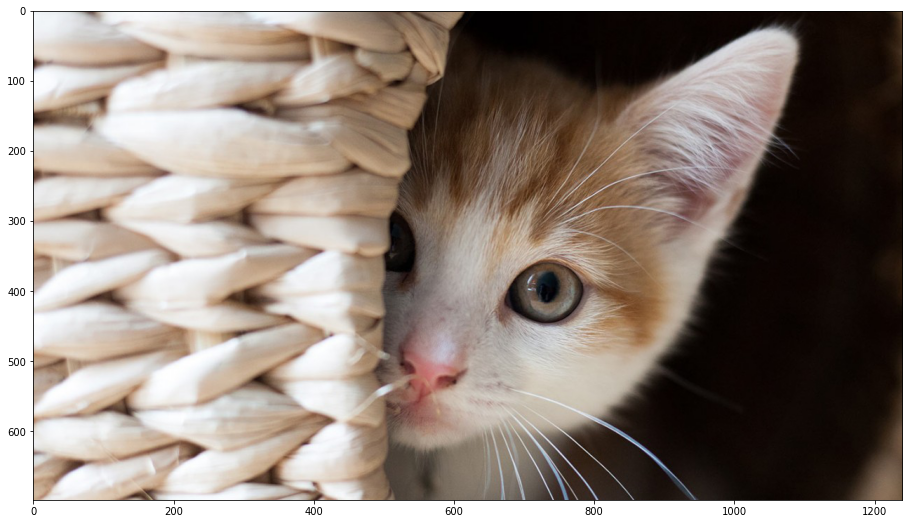

In [44]:
img = img_to_array(load_img(path+'input/hiding_cat.jpg'))
img = img/255

print('Forma de la imagen:',img.shape)
plt.imshow(img)

Para facilitar la interpretación de los resultados posteriores, vamos a transformar la imagen a escala de blanco y negro.

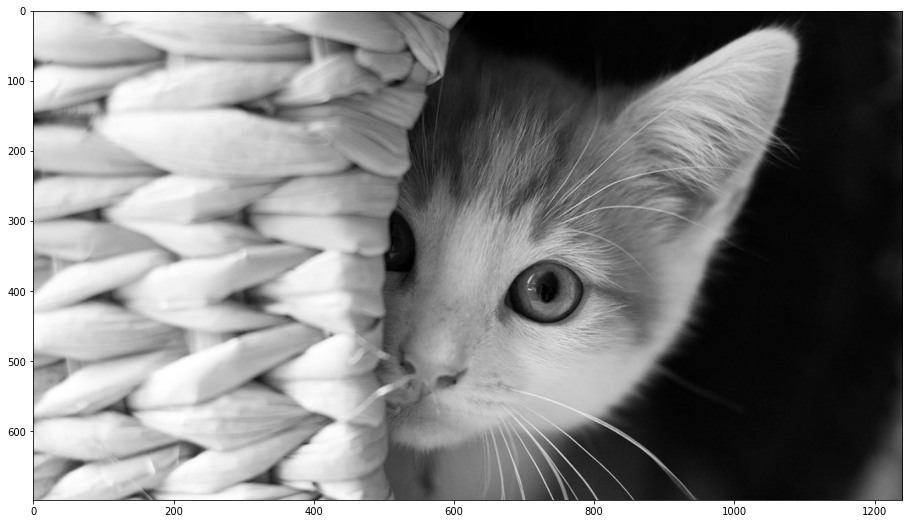

In [45]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img,cmap="gray")

### Efecto de Capa Convolucional
Uno de los objetivos de las capas convoluciones de una Red Neuronal es la detección de bordes en imágenes. 

Vamos a definir una convolución manualmente (definir Kernel) para aprender como impacta en la figura resultante.


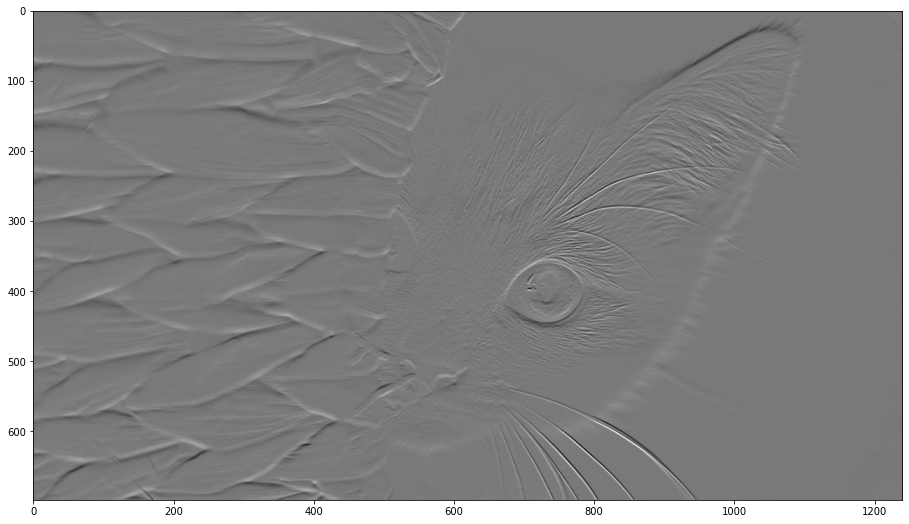

In [46]:
from scipy import signal

# Edge Detection Kernel
kernel = np.array([[-1., -2., -1.], 
                   [0.,  0.,  0.], 
                   [1.,  2.,  1.]])

grad = signal.convolve2d(img, kernel, boundary='symm', mode='same')

plt.imshow(grad,cmap="gray")

## Efecto de capa Max Pooling
Max Pooling es una técnica para reducir el número de píxeles en una imagen

<img src="https://miro.medium.com/max/847/1*FHPUtGrVP6fRmVHDn3A7Rw.png">

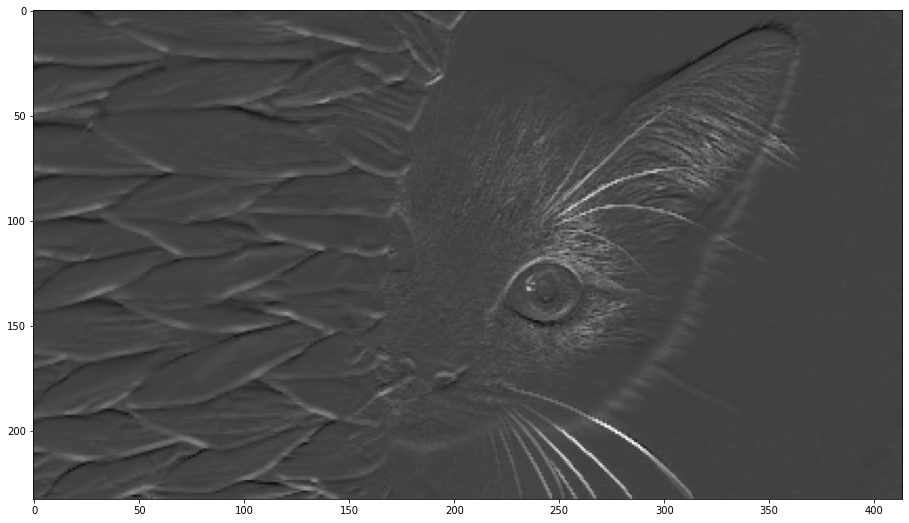

In [25]:
grad_with_maxpool = skimage.measure.block_reduce(grad, (3,3), np.max)
plt.imshow(grad_with_maxpool,cmap="gray")

## Construcción de Red Neuronal convolucional

### Primera arquitectura

<img src="https://drive.google.com/uc?id=1pKvtAFQXkPXoxHWEo_DPzefH-fz86Fht">

Para la primera arquitectura de Red Neuronal Convolucional, vamos a imitar el modelo mostrado en la imagen anterior. 

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model_cnn1 = Sequential()

model_cnn1.add(Conv2D(10, (5, 5), input_shape=(img_rows, img_cols, img_channel)))
model_cnn1.add(Activation('relu'))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn1.add(Conv2D(20, (5, 5)))
model_cnn1.add(Activation('relu'))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn1.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn1.add(Dense(100))
model_cnn1.add(Activation('relu'))
model_cnn1.add(Dropout(0.25))
model_cnn1.add(Dense(len(clases), activation='softmax'))

model_cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 10)      760       
_________________________________________________________________
activation (Activation)      (None, 220, 220, 10)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 20)      5020      
_________________________________________________________________
activation_1 (Activation)    (None, 106, 106, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 56180)            

In [27]:
model_cnn1.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)

In [28]:
params = {
    'epochs':30,
    'batch_size':32
}

In [29]:
history = model_cnn1.fit(
    x_train, y_train, validation_data=(x_val, y_val),
    batch_size=params['batch_size'], epochs=params['epochs'])

Epoch 1/30
13/13 [==============================] - 31s 76ms/step - loss: 5.2705 - accuracy: 0.1420 - val_loss: 2.4737 - val_accuracy: 0.1707
Epoch 2/30
13/13 [==============================] - 0s 37ms/step - loss: 2.4262 - accuracy: 0.2439 - val_loss: 2.6386 - val_accuracy: 0.1805
Epoch 3/30
13/13 [==============================] - 0s 37ms/step - loss: 2.1743 - accuracy: 0.2654 - val_loss: 1.9566 - val_accuracy: 0.3561
Epoch 4/30
13/13 [==============================] - 0s 37ms/step - loss: 1.9069 - accuracy: 0.3529 - val_loss: 1.9713 - val_accuracy: 0.3805
Epoch 5/30
13/13 [==============================] - 0s 38ms/step - loss: 1.6174 - accuracy: 0.4492 - val_loss: 1.8961 - val_accuracy: 0.3415
Epoch 6/30
13/13 [==============================] - 0s 37ms/step - loss: 1.4855 - accuracy: 0.5125 - val_loss: 2.2961 - val_accuracy: 0.3415
Epoch 7/30
13/13 [==============================] - 0s 36ms/step - loss: 1.3995 - accuracy: 0.5353 - val_loss: 1.8679 - val_accuracy: 0.4146
Epoch 8/30
1

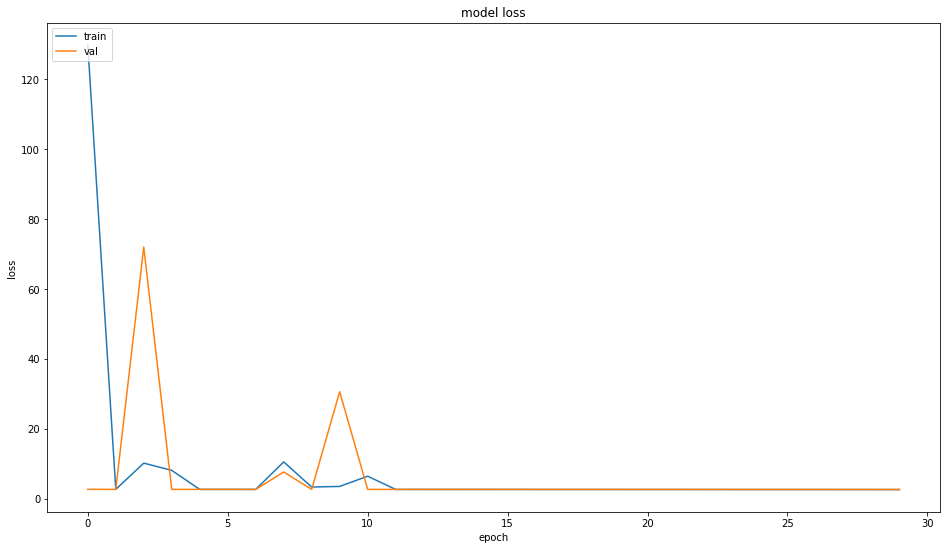

In [30]:
# summarize history for loss
#  Error en los datos de entrenamiento
plt.plot(history_mlp.history['loss'])
#  Error en los datos de validación
plt.plot(history_mlp.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se puede comprobar como el modelo ahora SI está prediciendo más allá de la clase

In [31]:
np.argmax(model_cnn1.predict(x_test), axis=1)

array([ 5,  5,  5, 13, 11,  1,  1,  5,  5,  5,  1,  5,  5,  1, 10,  9, 10,
        1,  0,  9,  9,  9,  5,  4,  9,  3,  5,  7, 13,  5,  5,  7,  9,  0,
        3,  9,  5,  0,  3,  3,  0,  5,  3,  5,  5,  0,  5,  3,  3,  5,  9,
        1,  5,  3,  3,  7,  8,  5,  9,  5,  5,  3,  3, 10,  3,  5,  3,  4,
        1,  5,  5,  5,  9,  4,  5,  5,  9,  7,  3,  5,  9,  5,  5,  5,  0,
        5,  0,  9,  1,  5,  0,  7,  3,  3,  3,  5,  9,  3,  1,  6,  3,  1,
        7,  6,  7,  5,  4,  5,  0, 11,  3,  5, 10,  5,  7,  3,  9,  0,  3,
       11, 10,  4,  4,  4,  5,  2,  5,  2,  0,  9,  2,  5,  4, 10,  1,  5,
        5, 11,  0,  7,  3,  4,  1,  4,  0,  0])

### Segunda arquitectura
Vamos ahora a modificar la arquitectura anterior. Los cambios que vamos a hacer son:
- Aumentar el número de capas convolucionales 2 -> 3
- Reducir el tamaño de los kernel 5,5 -> 3,3

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model_cnn2 = Sequential()

model_cnn2.add(Conv2D(10, (3, 3), input_shape=(img_rows, img_cols, img_channel)))
model_cnn2.add(Activation('relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn2.add(Conv2D(20, (3, 3)))
model_cnn2.add(Activation('relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn2.add(Conv2D(30, (3, 3)))
model_cnn2.add(Activation('relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn2.add(Dense(100))
model_cnn2.add(Activation('relu'))
model_cnn2.add(Dropout(0.25))
model_cnn2.add(Dense(len(clases), activation='softmax'))

model_cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
activation_3 (Activation)    (None, 222, 222, 10)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 20)      1820      
_________________________________________________________________
activation_4 (Activation)    (None, 109, 109, 20)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 52, 52, 30)       

In [33]:
model_cnn2.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)

params = {
    'epochs':30,
    'batch_size':32
}

history_cnn2 = model_cnn2.fit(
    x_train, y_train, validation_data=(x_val, y_val),
    batch_size=params['batch_size'], epochs=params['epochs'])

Epoch 1/30
13/13 [==============================] - 2s 79ms/step - loss: 3.2070 - accuracy: 0.1698 - val_loss: 2.2434 - val_accuracy: 0.2585
Epoch 2/30
13/13 [==============================] - 0s 31ms/step - loss: 2.1275 - accuracy: 0.2918 - val_loss: 1.9560 - val_accuracy: 0.3317
Epoch 3/30
13/13 [==============================] - 0s 29ms/step - loss: 1.8928 - accuracy: 0.3655 - val_loss: 1.7294 - val_accuracy: 0.4098
Epoch 4/30
13/13 [==============================] - 0s 30ms/step - loss: 1.6539 - accuracy: 0.4562 - val_loss: 1.8012 - val_accuracy: 0.3951
Epoch 5/30
13/13 [==============================] - 0s 31ms/step - loss: 1.5404 - accuracy: 0.4860 - val_loss: 1.9382 - val_accuracy: 0.3610
Epoch 6/30
13/13 [==============================] - 0s 31ms/step - loss: 1.5775 - accuracy: 0.4497 - val_loss: 1.5050 - val_accuracy: 0.5122
Epoch 7/30
13/13 [==============================] - 0s 29ms/step - loss: 1.2415 - accuracy: 0.6019 - val_loss: 2.0037 - val_accuracy: 0.3756
Epoch 8/30
13

Se puede comprobar que existe una mejora en la capacidad predictiva respecto a los modelos previos. 

Además, se puede comprobar como el modelo va aprendiendo poco a poco y tanto train como validación tienen un comportamiento parecido. Esto es algo que nos gustaría encontrar.

Sin embargo, a partir de la época ~7 se puede ver como existe un cambio de tendencia en el train y validación. Mientras el modelo es capaz de predecir mejor los datos de "train", el modelo cada vez falla más con los datos de "validación". A este fenómeno se le llama overfit, y se debería de evitar.

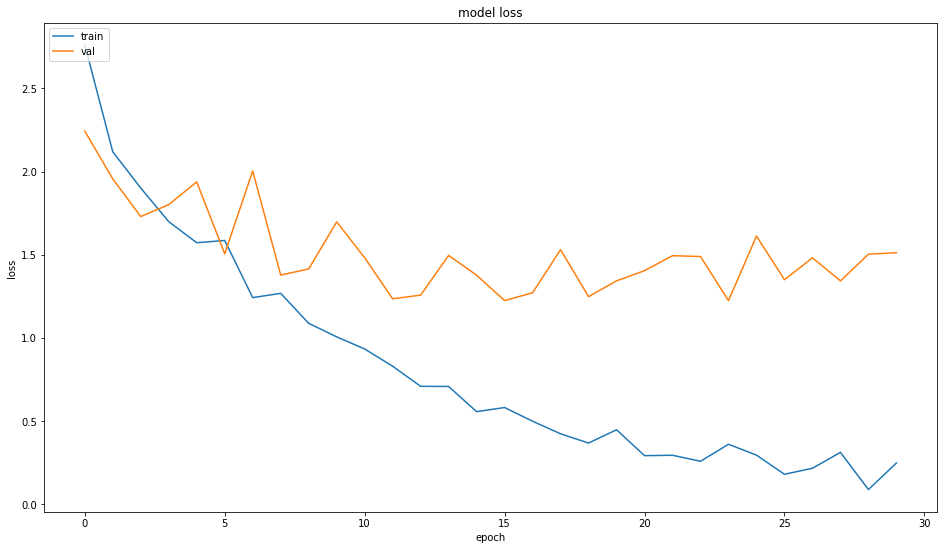

In [34]:
# summarize history for loss
plt.plot(history_cnn2.history['loss'])
plt.plot(history_cnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Característica CNN - Invarianza transaccional
Una características de las redes convolucionales, la invarianza transaccional. Esta características significa que da igual la localización del objeto que deseemos identificar, la red neuronal será capaz de identificarlo. 

<img src="https://drive.google.com/uc?id=1GHahCzwXrx_N9c0mTOMFeu3UwDJmYGaL">

In [35]:
ar = [1,2,3,4,5,6,7]
col, shift_count = len(ar), 1
print(ar[(col-shift_count):], ar[:-shift_count])
print(ar[:shift_count], ar[shift_count:])

[7] [1, 2, 3, 4, 5, 6]
[1] [2, 3, 4, 5, 6, 7]


In [36]:
def horizontal_shift(img_orig, shift=0.0):
    if shift > 1 or shift < 0:
        print('Los valores tienen que estar en el rango de 0 y 1')
        return img_orig
    
    col = img_orig.shape[-2]
    shift_count = int(np.round(shift * col))
    
    if shift_count==col or shift_count==0:
        return img_orig
    else:
        img = img_orig.copy()
        img_copy = img_orig.copy() 
        #print(col, shift_count, img_copy[:,(col-shift_count):,:].shape, img_copy[:,:-shift_count,:].shape)
        #print(img[:,:shift_count,:].shape, img[:,shift_count:,:].shape)
        
        img[:,:shift_count,:] = img_copy[:,(col-shift_count):,:]
        img[:,shift_count:,:] = img_copy[:,:-shift_count,:]
        return img

Rotación: 0 º
Predicción Máxima MLP - clase: 5 ; Probabilidad: 0.09496425
Predicción Máxima CNN - clase: 1 ; Probabilidad: 0.99647504


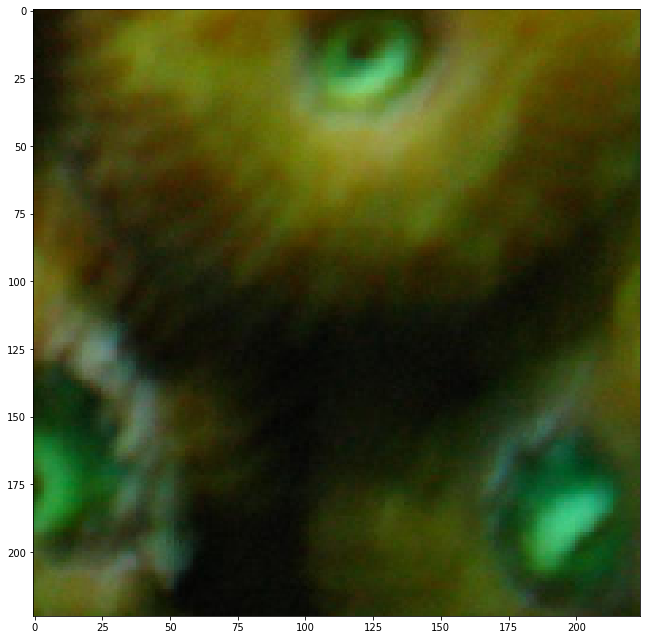

Rotación: 10 º
Predicción Máxima MLP - clase: 5 ; Probabilidad: 0.09496425
Predicción Máxima CNN - clase: 1 ; Probabilidad: 0.9416915


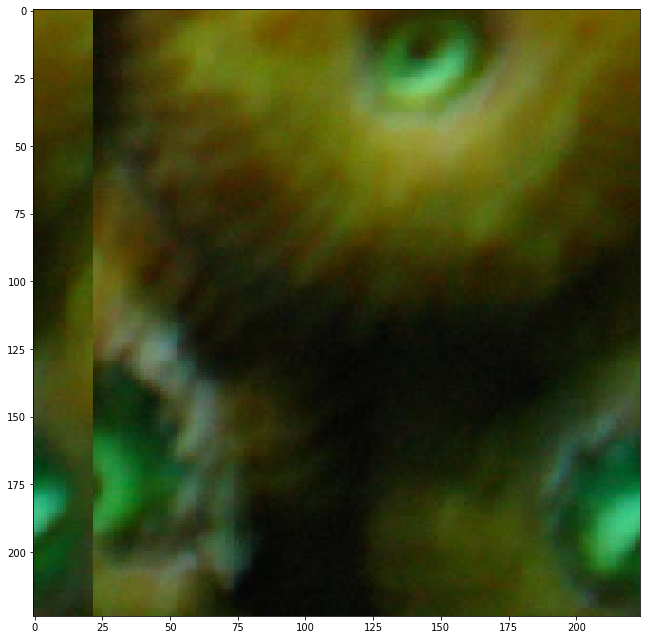

Rotación: 20 º
Predicción Máxima MLP - clase: 5 ; Probabilidad: 0.09496425
Predicción Máxima CNN - clase: 1 ; Probabilidad: 0.7328904


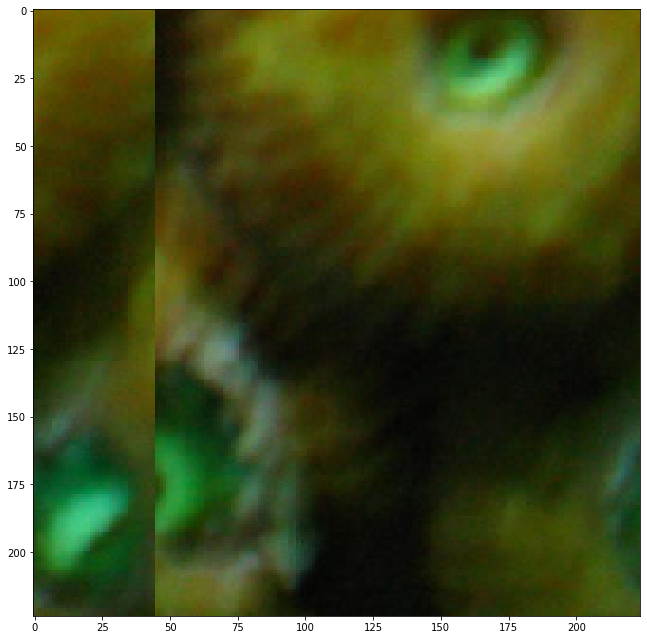

Rotación: 30 º
Predicción Máxima MLP - clase: 5 ; Probabilidad: 0.09496425
Predicción Máxima CNN - clase: 5 ; Probabilidad: 0.60862166


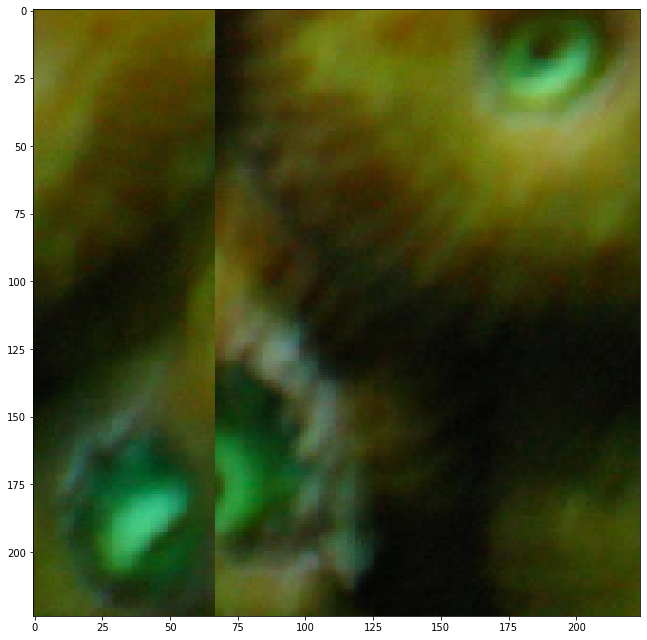

Rotación: 40 º
Predicción Máxima MLP - clase: 5 ; Probabilidad: 0.09496425
Predicción Máxima CNN - clase: 5 ; Probabilidad: 0.96175534


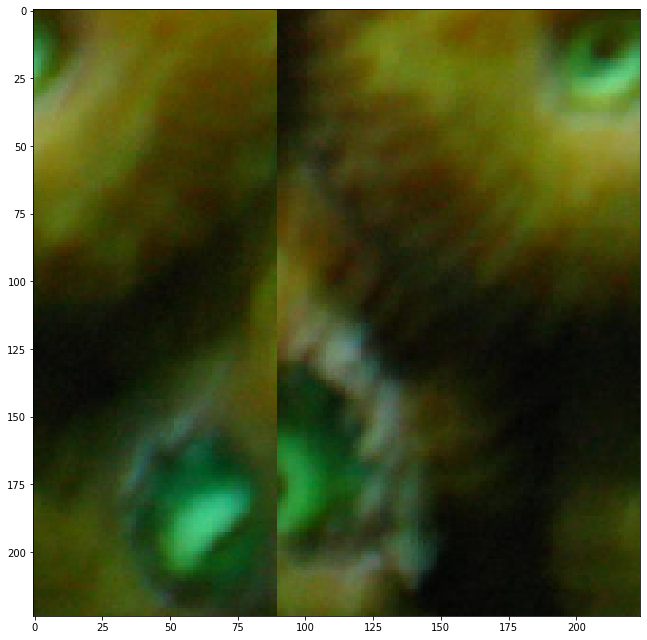

Rotación: 50 º
Predicción Máxima MLP - clase: 5 ; Probabilidad: 0.09496425
Predicción Máxima CNN - clase: 5 ; Probabilidad: 0.9245696


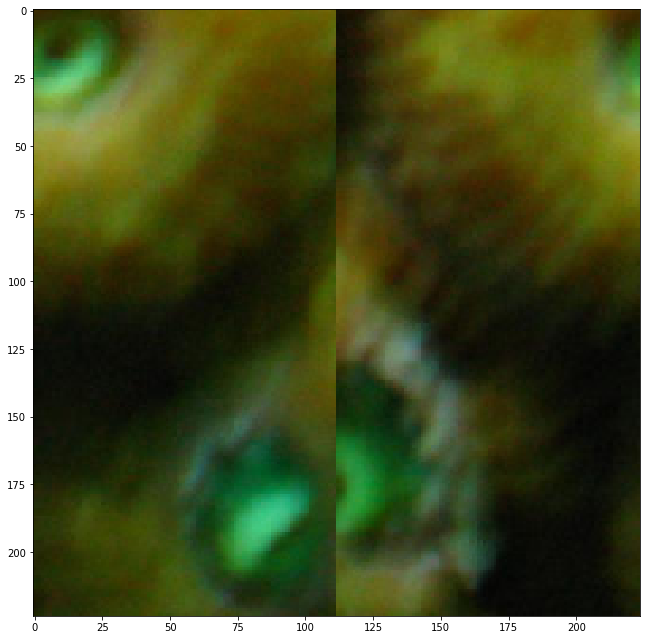

Rotación: 60 º
Predicción Máxima MLP - clase: 5 ; Probabilidad: 0.09496425
Predicción Máxima CNN - clase: 5 ; Probabilidad: 0.8962077


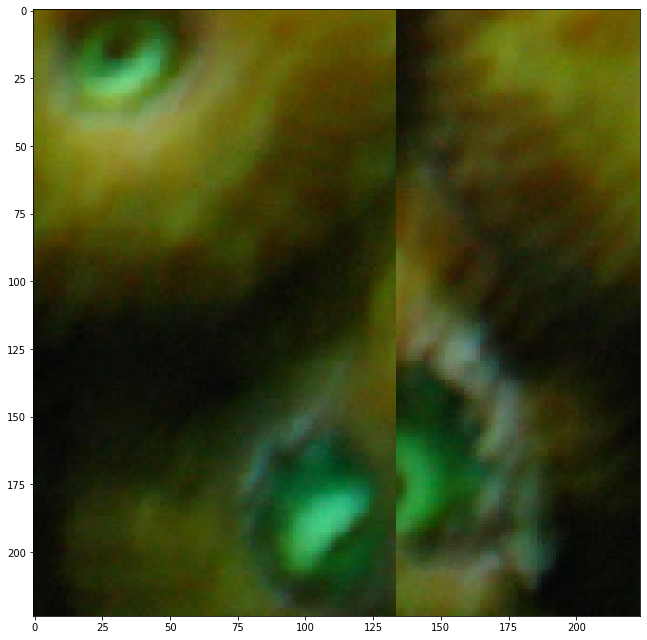

Rotación: 70 º
Predicción Máxima MLP - clase: 5 ; Probabilidad: 0.09496425
Predicción Máxima CNN - clase: 5 ; Probabilidad: 0.6549795


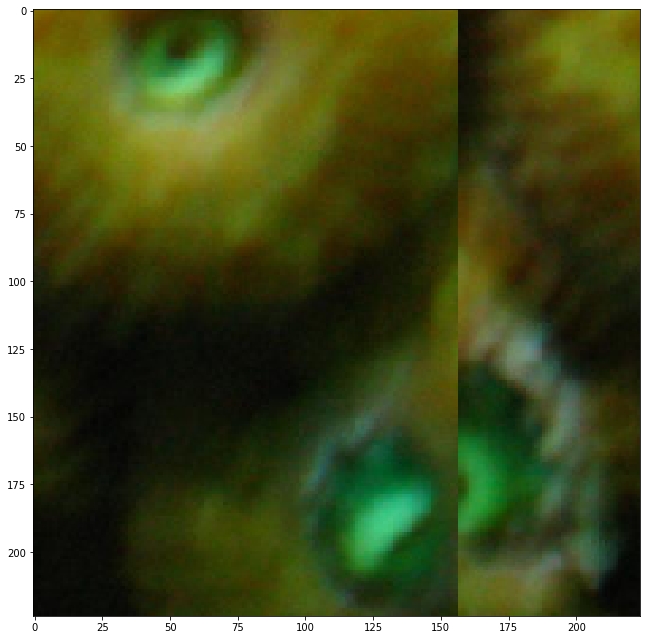

In [37]:
for shift in range(0,8):
    print('Rotación:',shift*10,'º')
    moved_image = horizontal_shift(x_train[2], shift/10)
    #print(model_mlp.predict(moved_image.reshape(1,224,224,3)))
    pred_mlp = model_mlp.predict(moved_image.reshape(1,224,224,3))
    print('Predicción Máxima MLP - clase:',np.argmax(pred_mlp),'; Probabilidad:', np.max(pred_mlp))
    #print(model_cnn2.predict(moved_image.reshape(1,224,224,3)))
    pred_cnn = model_cnn2.predict(moved_image.reshape(1,224,224,3))
    print('Predicción Máxima CNN - clase:',np.argmax(pred_cnn),'; Probabilidad:',np.max(pred_cnn))
    io.imshow(moved_image)
    plt.show()

# Pre-trained neural network
Vamos ahora utilizar redes pre-entrenadas

Primero, chequeemos la forma que tiene una de las redes más simples VGG16.
https://keras.io/api/applications/

## VGG16

In [38]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

#include_top: Especifica si incluir las 3 capas fully connected finales de la red
#weights: Especifica los pesos de la red
# - None: Inicialización aleatoria de los pesos
# - Imagenet: Pesos de la red cuando se entrenó con la Red Imagenet
# - Ruta (localización): Poner una ruta donde se encuentran los pesos de la red
#input_shape: tamaño de la red de entrada
base_model = VGG16(input_shape=x_train[0].shape, include_top=False, weights='imagenet', pooling="avg")

# Mediante la siguiente línea se puede decidir si entrenar o no el modelo
base_model.trainable = False

base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

**Notas:**
- Se recomienda añadir **dos fully** connected layers después del modelo pre-entrenado para utilizarlo
- Dependiendo del **número de ejemplos** que se dispongan, se recomienda permitir **entrenar más o menos capas del final**
    - Si hay muy pocos, dejar la red fija (trainable = False) y entrenar las últimas capas
    - Si hay varios, entrenar las últimas capas (primeras capas: trainable = False y últimas capas: trainable = True) 
- Muchos modelos contienen capas de **BatchNormalization**. Esta capa es un **caso especial** y se deben tomar precauciones en el contexto del ajuste fino. **Probar con entrenarlas**.

https://keras.io/api/models/model/

In [39]:
from tensorflow.keras import Model

base_model = VGG16(input_shape=x_train[0].shape, include_top=False, weights='imagenet', pooling="avg")

# Mediante la siguiente línea se puede decidir si entrenar o no el modelo
base_model.trainable = False

base_model_modified_dropout = Dropout(0.5)(base_model.output)
base_model_modified_fc1 = Dense(128)(base_model_modified_dropout)
output = Dense(len(clases), activation='softmax')(base_model_modified_fc1)

# Cuando no se utiliza sequential, hay que especificar la capa de input y output de la red
#  Para ello se utiliza la función "Model" de Keras
#  Destacar que se pueden introducir varias capas de input y output distintas
model_cnn3 = Model(inputs=base_model.input,outputs=output)
model_cnn3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [40]:
model_cnn3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

params = {
    'epochs':30,
    'batch_size':32
}

history_cnn3 = model_cnn3.fit(
    x_train, y_train, validation_data=(x_val, y_val),
    batch_size=params['batch_size'], epochs=params['epochs'])

Epoch 1/30
13/13 [==============================] - 20s 1s/step - loss: 2.8418 - accuracy: 0.1044 - val_loss: 2.3231 - val_accuracy: 0.2732
Epoch 2/30
13/13 [==============================] - 3s 225ms/step - loss: 2.3021 - accuracy: 0.2532 - val_loss: 2.0345 - val_accuracy: 0.4878
Epoch 3/30
13/13 [==============================] - 3s 225ms/step - loss: 2.0710 - accuracy: 0.3270 - val_loss: 1.8908 - val_accuracy: 0.4683
Epoch 4/30
13/13 [==============================] - 3s 225ms/step - loss: 1.8692 - accuracy: 0.4504 - val_loss: 1.7257 - val_accuracy: 0.5756
Epoch 5/30
13/13 [==============================] - 3s 222ms/step - loss: 1.6693 - accuracy: 0.5348 - val_loss: 1.5976 - val_accuracy: 0.5415
Epoch 6/30
13/13 [==============================] - 3s 222ms/step - loss: 1.5605 - accuracy: 0.5361 - val_loss: 1.5105 - val_accuracy: 0.6439
Epoch 7/30
13/13 [==============================] - 3s 222ms/step - loss: 1.5182 - accuracy: 0.5732 - val_loss: 1.4620 - val_accuracy: 0.5659
Epoch 8/

Vamos ahora a utilizar una red pre-entrenada más pontente. 

In [41]:
from tensorflow.keras.applications import InceptionV3

def get_model_inceptionv3():
  base_model = InceptionV3(input_shape=x_train[0].shape, include_top=False, weights='imagenet', pooling="max")

  base_model.trainable = False

  for layer in base_model.layers:
    if 'BatchNormalization' in str(layer):
      layer.trainable = False
    else:
      layer.trainable = False
      
  base_model_modified_dropout = Dropout(0.5)(base_model.output)
  base_model_modified_fc1 = Dense(128)(base_model_modified_dropout)
  output = Dense(len(clases), activation='softmax')(base_model_modified_fc1)

  model_cnn4 = Model(inputs=base_model.input, outputs=output)
  return model_cnn4

model_cnn4 = get_model_inceptionv3()
model_cnn4.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 111, 111, 32) 0           batch_normalization[0][0]        
___________________________

In [42]:
model_cnn4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

params = {
    'epochs':30,
    'batch_size':32
}

history_cnn4 = model_cnn4.fit(
    x_train, y_train, validation_data=(x_val, y_val),
    batch_size=params['batch_size'], epochs=params['epochs'])

Epoch 1/30
13/13 [==============================] - 9s 379ms/step - loss: 8.9501 - accuracy: 0.1306 - val_loss: 4.3223 - val_accuracy: 0.3366
Epoch 2/30
13/13 [==============================] - 1s 117ms/step - loss: 3.9956 - accuracy: 0.4401 - val_loss: 1.5176 - val_accuracy: 0.6146
Epoch 3/30
13/13 [==============================] - 1s 116ms/step - loss: 1.9202 - accuracy: 0.6349 - val_loss: 0.7933 - val_accuracy: 0.7659
Epoch 4/30
13/13 [==============================] - 1s 117ms/step - loss: 1.3017 - accuracy: 0.6997 - val_loss: 0.8109 - val_accuracy: 0.7902
Epoch 5/30
13/13 [==============================] - 1s 117ms/step - loss: 0.6276 - accuracy: 0.8451 - val_loss: 0.6753 - val_accuracy: 0.8488
Epoch 6/30
13/13 [==============================] - 1s 116ms/step - loss: 0.5884 - accuracy: 0.8499 - val_loss: 0.5510 - val_accuracy: 0.8341
Epoch 7/30
13/13 [==============================] - 1s 117ms/step - loss: 0.3316 - accuracy: 0.9106 - val_loss: 0.6769 - val_accuracy: 0.8634
Epoch 

# Image augmentation
Debido a que disponemos de pocos ejemplos, vamos a generar nuevas imágenes con las que poder aprender a partir de las imágenes originales

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Página de referencia: https://keras.io/api/preprocessing/image/
datagen = ImageDataGenerator(
                
                featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False,
                zca_epsilon=1e-06,
                rotation_range=0,
                width_shift_range=0.0,
                height_shift_range=0.0,
                brightness_range=None,
                shear_range=0.0,
                zoom_range=0.0,
                channel_shift_range=0.0,
                fill_mode="nearest",
                cval=0.0,
                horizontal_flip=False,
                vertical_flip=False,
                rescale=None,
                preprocessing_function=None,
                data_format=None,
                validation_split=0.0,
                dtype=np.float32
        ) 

history_cnn4_aug = get_model_inceptionv3()

history_cnn4_aug.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
params = {
    'epochs':30,
    'batch_size':64
}

history_cnn4_aug.fit_generator(
                            datagen.flow(x_train, y_train, batch_size=params['batch_size']),
                             validation_data=(x_val, y_val), epochs=params['epochs'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
7/7 [==============================] - 8s 390ms/step - loss: 9.3759 - accuracy: 0.0838 - val_loss: 3.0048 - val_accuracy: 0.3415
Epoch 2/30
7/7 [==============================] - 1s 212ms/step - loss: 4.2331 - accuracy: 0.3614 - val_loss: 2.7168 - val_accuracy: 0.4488
Epoch 3/30
7/7 [==============================] - 1s 219ms/step - loss: 2.6146 - accuracy: 0.5310 - val_loss: 1.7845 - val_accuracy: 0.6244
Epoch 4/30
7/7 [==============================] - 1s 209ms/step - loss: 1.6803 - accuracy: 0.6124 - val_loss: 0.8299 - val_accuracy: 0.7317
Epoch 5/30
7/7 [==============================] - 1s 210ms/step - loss: 1.0215 - accuracy: 0.7618 - val_loss: 0.7628 - val_accuracy: 0.7805
Epoch 6/30
7/7 [==============================] - 1s 208ms/step - loss: 0.6399 - accuracy: 0.8308 - val_loss: 0.8418 - val_accuracy: 0.7854
Epoch 7/30
7/7 [==============================] - 1s 210ms/step - loss: 0.8328 - accuracy: 0.8270 - val_loss: 0.8438 - val_accuracy: 0.7854
Epoch 8/30
7/7 [====

# Ejercicios

- Introducir pesos a las clases de los corales para equilibrar el entrenamiento (class_weight)
  - $WeightClase_x$ = 1 / Total apariciones $clase_x$ 
- Probar con el modelo ResNet50 ¿Qué sucede?
- Probad a entrenar la última capa y anteúltima del modelo VGG16
- Probar cambiando el pooling 'avg' de los modelos pre-entrenados por 'max' ¿Qué sucede? ¿Hay cambios?
- Probar si la invarianza transaccional sigue funcionando con los modelos pre-entrenados
- Intentar mejorar los resultados del modelo Image Augmentation modificando
  - Los parámetros del DataGen
  - Introduciendo regularización 
  - Cambiando el número de neuronas
  - Modificando Batch Size y Optimizer